In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_GD1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_GD1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_GD1['SOURCE_KEY'] = df_GD1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_GD1['DATE_TIME'] = pd.to_datetime(df_GD1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD1_with_weather = pd.merge(df_GD1, plant_1_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD1_with_weather_clean = df_GD1_with_weather.drop(columns=['SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD1_with_weather_clean = df_GD1_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY', 'PLANT_ID_y':'PLANT_ID'})

nulos = df_GD1_with_weather_clean.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols = df_GD1_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns #Estp para quitar los floats
df_GD1_with_weather_clean[numerical_cols] = df_GD1_with_weather_clean[numerical_cols].fillna(df_GD1_with_weather_clean[numerical_cols].mean())

df_GD1_limpio = df_GD1_with_weather_clean;

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
PLANT_ID               4
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


In [4]:
# Cargar los datos de generación y meteorológicos para la planta 2
plant_2_generation = pd.read_csv('Plant_2_Generation_Data.csv')
plant_2_weather = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD2 limpio
df_GD2 = plant_2_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list_2 = df_GD2['SOURCE_KEY'].unique()
source_key_mapping_2 = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list_2)}
df_GD2['SOURCE_KEY'] = df_GD2['SOURCE_KEY'].map(source_key_mapping_2)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
# Ajustar el formato de fecha según sea necesario para que coincida con el archivo de la planta 2
df_GD2['DATE_TIME'] = pd.to_datetime(df_GD2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
plant_2_weather['DATE_TIME'] = pd.to_datetime(plant_2_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD2_with_weather = pd.merge(df_GD2, plant_2_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD2_with_weather_clean = df_GD2_with_weather.drop(columns=['SOURCE_KEY_y', 'PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD2_with_weather_clean = df_GD2_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY', 'PLANT_ID_Y':'PLANT_ID'})

# Mostrar cuántos valores nulos hay por columna
nulos2 = df_GD2_with_weather_clean.isnull().sum()
print("Valores nulos en cada columna (planta 2):\n", nulos2)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols_2 = df_GD2_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns
df_GD2_with_weather_clean[numerical_cols_2] = df_GD2_with_weather_clean[numerical_cols_2].fillna(df_GD2_with_weather_clean[numerical_cols_2].mean())

# Guardar el dataframe limpio de la planta 2
df_GD2_limpio = df_GD2_with_weather_clean

Valores nulos en cada columna (planta 2):
 DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
PLANT_ID_y             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [5]:
# Supongo que ya has preprocesado los datos de ambas plantas y los has combinado
df_combined = pd.concat([df_GD1_limpio, df_GD2_limpio], ignore_index=True)

# Añadir una columna 'ZONE' para indicar la planta utilizando 'PLANT_ID'
df_combined['ZONE'] = df_combined['PLANT_ID'].apply(lambda x: 1 if x == 4135001 else 2)

# Separar características (X) y etiquetas (y)
features = ['DC_POWER','AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X = df_combined[features].values
y = df_combined['ZONE']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de Regresión Logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test_scaled)

# Generar un informe de clasificación
report = classification_report(y_test, y_pred, target_names=['Plant_1', 'Plant_2'], labels=[1, 2])
print(report)


              precision    recall  f1-score   support

     Plant_1       0.92      0.97      0.95     13825
     Plant_2       0.97      0.92      0.94     13471

    accuracy                           0.95     27296
   macro avg       0.95      0.95      0.95     27296
weighted avg       0.95      0.95      0.95     27296



                  precision   recall   f1-score  support

     Plant_1       0.85      0.96      0.90     13825
     Plant_2       0.95      0.82      0.88     13471

      accuracy                           0.89     27296
      macro avg     0.90      0.89      0.89     27296
      weighted avg   0.90      0.89      0.89     27296


In [6]:
RF_model = RandomForestClassifier(n_estimators=250, random_state=42)

RF_model.fit(X_train_scaled,y_train)
RF_y_pred = RF_model.predict(X_test_scaled)

report = classification_report(y_test, y_pred, target_names=['Plant_1', 'Plant_2'], labels=[1, 2])
print(report)

              precision    recall  f1-score   support

     Plant_1       0.92      0.97      0.95     13825
     Plant_2       0.97      0.92      0.94     13471

    accuracy                           0.95     27296
   macro avg       0.95      0.95      0.95     27296
weighted avg       0.95      0.95      0.95     27296



In [7]:
CV_model = cross_val_score(RF_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f'Puntajes de la validación cruzada: {CV_model}')
print(f'Media de la validación cruzada: {np.mean(CV_model):.2f}')

Puntajes de la validación cruzada: [1.         1.         1.         0.99990841 1.        ]
Media de la validación cruzada: 1.00


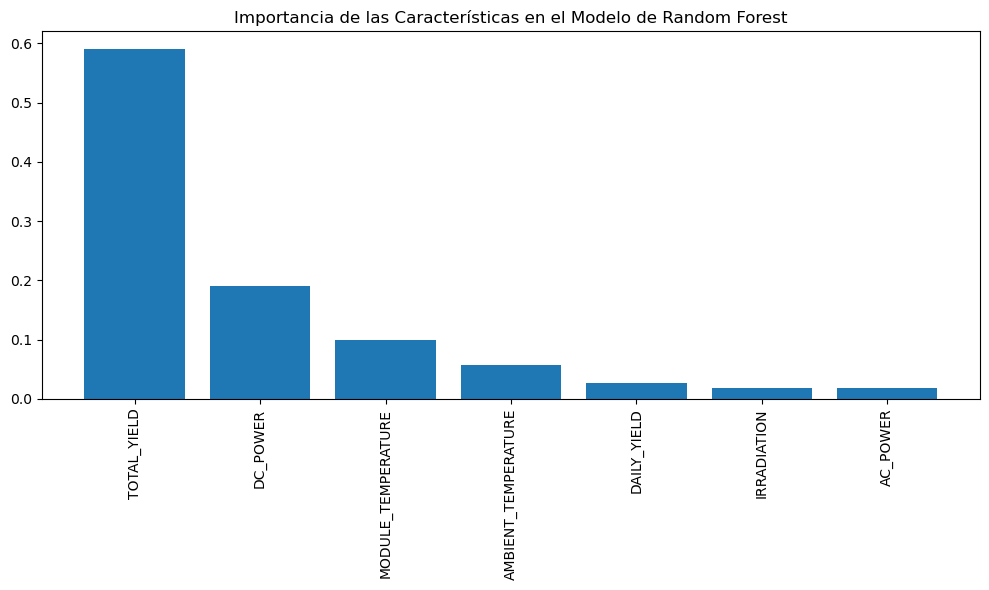

In [8]:
# Visualizar la importancia de las características (asegurando que el modelo es RandomForestClassifier)
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = df_combined.drop(['ZONE', 'PLANT_ID','DATE_TIME','SOURCE_KEY'], axis=1).columns

plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características en el Modelo de Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()
